In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as spla
from scipy import sparse
import time
from IPython.display import display, clear_output
import finite_week5 as finite 
import timesteppers_hw5 as timesteppers 

## Viscous Burgers' Equation

Standard Burgers' equation is a bit tricky, so we will add on a diffusion term
$$\partial_t u - \nu\partial_x^2 u = - u\partial_x u.$$
The diffusion term ($-\nu\partial_x^2 u$) is a linear term, and as we described last time, it is difficult to timestep explicitly. So we need to switch to an IMEX scheme, where the diffusion term is treated implicitly, as the advection term is treated explicitly. 

We want to be able to solve general equations of the form
$$M \partial_t X + L X = F(X),$$
so we will be making an equation set which we will pass to our timestepper. The equation set needs to specify the variables we're solving for `X`, the matrices `M` and `L`, and the `F` operator.

`X` here is a `StateVector`. This is how we will store multiple variables simultaneously, and also allow for coupling between the different variables for the implicit part of the timestepping. The `StateVector` has a list of variables, and also has a `data` attribute which is a single vector containing the variable data. The `gather` and `scatter` methods move data from the variables and the vector, and vice versa.

In [ ]:
class StateVector:
    '''
    X
    Make it long vector. 
    '''
    def __init__(self, variables):
        var0 = variables[0]
        self.N = len(var0)
        size = self.N*len(variables) # pass in variables 
        self.data = np.zeros(size)
        self.variables = variables
        self.gather() # takes numbers in var into .data
    # Take the number in these vector to the variable and slot them into the correct spot.
    def gather(self): 
        for i, var in enumerate(self.variables):
            np.copyto(self.data[i*self.N:(i+1)*self.N], var)
    # Does the put them back to variables 
    def scatter(self):
        for i, var in enumerate(self.variables):
            np.copyto(var, self.data[i*self.N:(i+1)*self.N])

In [4]:
grid = finite.UniformPeriodicGrid(200, 5)
x = grid.values

# Initial condition 
IC = 0*x
for i, xx in enumerate(x):
    if xx > 1 and xx <= 2:
        IC[i] = (xx-1)
    elif xx > 2 and xx < 3:
        IC[i] = (3-xx)

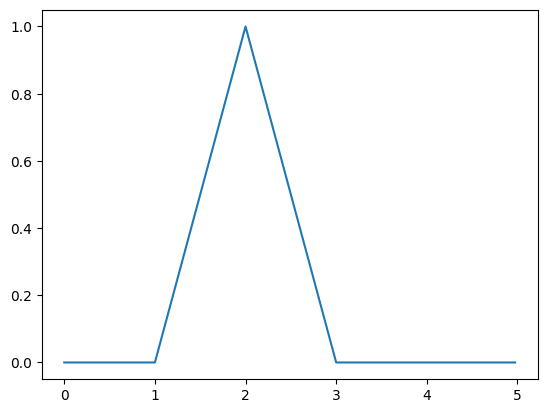

In [5]:
plt.figure()
plt.plot(x, IC)

In [6]:
u = np.copy(IC)

In [7]:
X = StateVector([u])

In [ ]:
X.data # list all the number 

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.025, 0.05 , 0.075, 0.1  ,
       0.125, 0.15 , 0.175, 0.2  , 0.225, 0.25 , 0.275, 0.3  , 0.325,
       0.35 , 0.375, 0.4  , 0.425, 0.45 , 0.475, 0.5  , 0.525, 0.55 ,
       0.575, 0.6  , 0.625, 0.65 , 0.675, 0.7  , 0.725, 0.75 , 0.775,
       0.8  , 0.825, 0.85 , 0.875, 0.9  , 0.925, 0.95 , 0.975, 1.   ,
       0.975, 0.95 , 0.925, 0.9  , 0.875, 0.85 , 0.825, 0.8  , 0.775,
       0.75 , 0.725, 0.7  , 0.675, 0.65 , 0.625, 0.6  , 0.575, 0.55 ,
       0.525, 0.5  , 0.475, 0.45 , 0.425, 0.4  , 0.375, 0.35 , 0.325,
       0.3  , 0.275, 0.25 , 0.225, 0.2  , 0.175, 0.15 , 0.125, 0.1  ,
       0.075, 0.05 , 0.025, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   ,

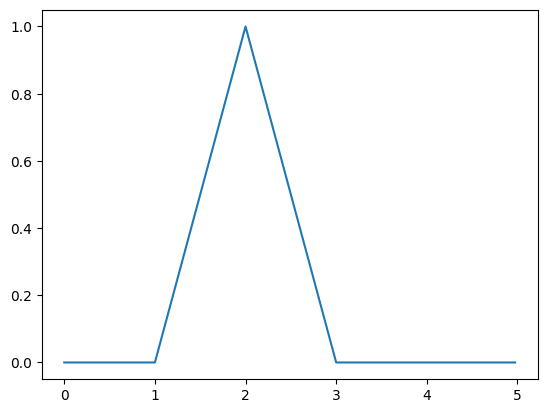

In [9]:
plt.figure()
plt.plot(x, X.data)

In [9]:
x_s = 1+np.sqrt(2+2*3)

sol = 0*x
for i, xx in enumerate(x):
    if xx > 1 and xx <= x_s:
        sol[i] = 2/(x_s-1)**2*(xx-1)
        
X.data = np.copy(sol)

In [10]:
X.scatter()

In [11]:
class ViscousBurgers:
    
    def __init__(self, u, nu, d, d2):
        self.X = StateVector([u])
        
        N = len(u)
        self.M = sparse.eye(N, N)
        self.L = -nu*d2.matrix
        
        f = lambda X: -X.data*(d @ X.data)
        
        self.F = f

## Backward/Forward Euler
Now we need to write the Forward/Backward Euler timestepper. This is
$$(M + \Delta t L)u^{n+1} = M u^{n} + \Delta t F(u^{n})$$
First, we have a general IMEX timestepping base class.

In [13]:
class IMEXTimestepper(timesteppers.Timestepper):

    def __init__(self, eq_set):
        super().__init__()
        self.X = eq_set.X
        self.M = eq_set.M
        self.L = eq_set.L
        self.F = eq_set.F

    def step(self, dt):
        self.X.data = self._step(dt)
        self.X.scatter()
        self.dt = dt
        self.t += dt
        self.iter += 1

In [14]:
class Euler(IMEXTimestepper):

    def _step(self, dt):
        if dt != self.dt:
            LHS = self.M + dt*self.L
            self.LU = spla.splu(LHS.tocsc(), permc_spec='NATURAL')

        RHS = self.M @ self.X.data + dt*self.F(self.X)
        return self.LU.solve(RHS)

In [15]:
grid = finite.UniformPeriodicGrid(200, 5)
x = grid.values

IC = 0*x
for i, xx in enumerate(x):
    if xx > 1 and xx <= 2:
        IC[i] = (xx-1)
    elif xx > 2 and xx < 3:
        IC[i] = (3-xx)

x_s = 1+np.sqrt(2+2*3)

sol = 0*x
for i, xx in enumerate(x):
    if xx > 1 and xx <= x_s:
        sol[i] = 2/(x_s-1)**2*(xx-1)

d = finite.DifferenceUniformGrid(1, 2, grid)
d2 = finite.DifferenceUniformGrid(2, 2, grid)
nu = 1e-2

u = np.copy(IC)
vburgers_problem = ViscousBurgers(u, nu, d, d2)

<ufunc 'solve1'>
<ufunc 'solve1'>


/opt/miniconda3/envs/446-1/lib/python3.12/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


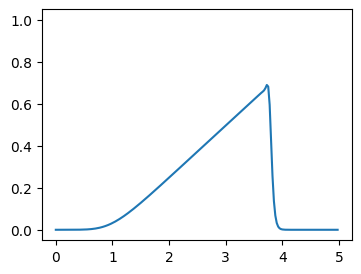

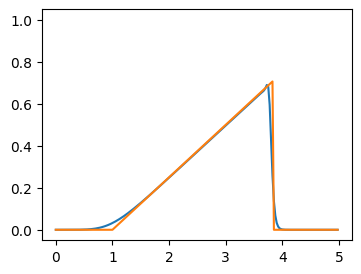

In [16]:
ts = Euler(vburgers_problem)

alpha = 0.8
dt = alpha*grid.dx
output_cadence = 2

fig = plt.figure(figsize=(4,3))
p, = plt.plot(x, u)
while ts.t < 3:
    ts.step(dt)
    if ts.iter % output_cadence == 0:
        p.set_ydata(u)
        clear_output(wait=True)
        display(fig)
plt.plot(x, sol)